# Deep Learning regularization

## Regularize a neural network with L2 regularization

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
# Explanation for normalization weird values: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081)), transforms.Lambda(torch.flatten)])

In [3]:
trainset = MNIST('./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = MNIST('./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
class Net(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int = 24):
        super(Net, self).__init__()
        self.hidden_units = hidden_units
        self.fc1 = nn.Linear(input_shape, self.hidden_units)
        self.fc2 = nn.Linear(self.hidden_units, self.hidden_units)
        self.output = nn.Linear(self.hidden_units, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = torch.softmax(self.output(x), dim=1)
        return output

In [5]:
# Instantiate the model
net = Net(784)
# Generate randomly one random 28x28 image as a 784 values tensor
random_data = torch.rand((1, 784))
result = net(random_data)
print('Resulting output tensor:', result)
print('Sum of the output tensor:', result.sum())

Resulting output tensor: tensor([[0.0839, 0.1061, 0.1094, 0.1006, 0.0939, 0.0847, 0.1112, 0.1057, 0.1014,
         0.1029]], grad_fn=<SoftmaxBackward0>)
Sum of the output tensor: tensor(1.0000, grad_fn=<SumBackward0>)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

In [7]:
def epoch_step(net, dataloader, training_set: bool):
    running_loss = 0.
    correct = 0.
    for i, data in enumerate(dataloader, 0):
        # Get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        if training_set:
            # Zero the parameter gradients
            optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        if training_set:
            loss.backward()
            optimizer.step()
        # Add correct predictions for this batch
        correct += (outputs.argmax(dim=1) == labels).float().sum()
        # Compute loss for this batch
        running_loss += loss.item()

    return running_loss, correct

In [7]:
# Create empty lists to store the losses and accuracies
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

# Loop over the dataset 20 times for 20 epochs
for epoch in range(20):  
    ## Train the model on the training set
    running_train_loss, correct = epoch_step(net, dataloader=train_dataloader, training_set=True)
    # Compute and store loss and accuracy for this epoch
    train_epoch_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    train_epoch_accuracy = correct / len(trainset)
    train_accuracy.append(train_epoch_accuracy)

    ## Evaluate the model on the test set
    #running_test_loss = 0.
    #correct = 0.
    net.eval()
    with torch.no_grad():
        running_test_loss, correct = epoch_step(net, dataloader=test_dataloader, training_set=False)

        test_epoch_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        test_epoch_accuracy = correct / len(testset)
        test_accuracy.append(test_epoch_accuracy)

    # Print stats
    print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
\t Test: loss={test_epoch_loss:.3f} accuracy={test_epoch_accuracy:.3f}')

print('Finished Training')

[epoch 1] Training: loss=1.690 accuracy=0.788 |	 Test: loss=1.626 accuracy=0.843
[epoch 2] Training: loss=1.623 accuracy=0.845 |	 Test: loss=1.619 accuracy=0.848
[epoch 3] Training: loss=1.614 accuracy=0.853 |	 Test: loss=1.609 accuracy=0.857
[epoch 4] Training: loss=1.608 accuracy=0.858 |	 Test: loss=1.605 accuracy=0.858
[epoch 5] Training: loss=1.567 accuracy=0.903 |	 Test: loss=1.528 accuracy=0.940
[epoch 6] Training: loss=1.524 accuracy=0.945 |	 Test: loss=1.525 accuracy=0.944
[epoch 7] Training: loss=1.518 accuracy=0.950 |	 Test: loss=1.520 accuracy=0.948
[epoch 8] Training: loss=1.516 accuracy=0.952 |	 Test: loss=1.513 accuracy=0.954
[epoch 9] Training: loss=1.514 accuracy=0.954 |	 Test: loss=1.513 accuracy=0.953
[epoch 10] Training: loss=1.512 accuracy=0.956 |	 Test: loss=1.511 accuracy=0.956
[epoch 11] Training: loss=1.511 accuracy=0.957 |	 Test: loss=1.511 accuracy=0.956
[epoch 12] Training: loss=1.510 accuracy=0.959 |	 Test: loss=1.516 accuracy=0.951
[epoch 13] Training: loss

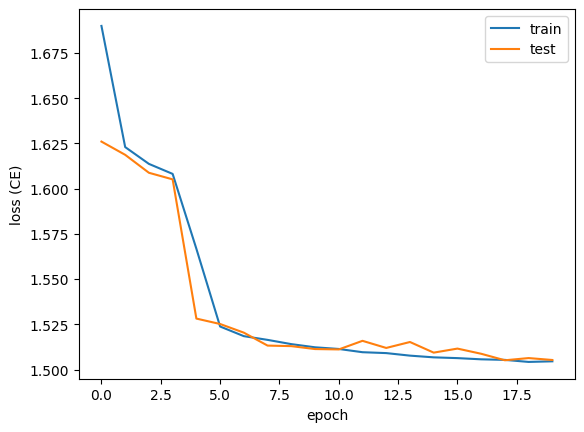

In [8]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (CE)')
plt.legend()
plt.show()

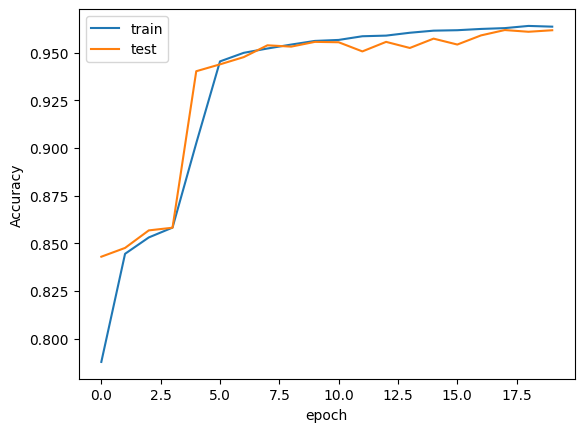

In [9]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Regularize a neural network with early stopping

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
X, y = load_breast_cancer(return_X_y=True)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X.astype(np.float32), y.astype(np.float32), test_size=0.2, random_state=0)

In [4]:
class BreastCancerDataset(Dataset):
    def __init__(self, X: np.array, y: np.array, x_scaler: StandardScaler = None):
        if x_scaler is None:
            self.x_scaler = StandardScaler()
            X = self.x_scaler.fit_transform(X)
        else:
            self.x_scaler = x_scaler
            X = self.x_scaler.transform(X)           
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor]:
        return self.X[idx], self.y[idx]


In [5]:
training_data = BreastCancerDataset(X_train, y_train)
val_data = BreastCancerDataset(X_val, y_val, training_data.x_scaler)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int = 36):
        super(Net, self).__init__()
        self.hidden_units = hidden_units
        self.fc1 = nn.Linear(input_shape, self.hidden_units)
        self.fc2 = nn.Linear(self.hidden_units, self.hidden_units)
        self.output = nn.Linear(self.hidden_units, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = torch.sigmoid(self.output(x))
        return output

In [7]:
# Instantiate the model
net = Net(X_train.shape[1])
# Generate randomly one random 28x28 image as a 784 values tensor
random_data = torch.rand((1, X_train.shape[1]))
result = net(random_data)
print('Resulting output tensor:', result)
print('Sum of the output tensor:', result.sum())

Resulting output tensor: tensor([[0.4910]], grad_fn=<SigmoidBackward0>)
Sum of the output tensor: tensor(0.4910, grad_fn=<SumBackward0>)


In [8]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [9]:
def epoch_step(net, dataloader, training_set: bool):
    running_loss = 0.
    correct = 0.
    for i, data in enumerate(dataloader, 0):
        # Get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.unsqueeze(1)
        if training_set:
            # Zero the parameter gradients
            optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        if training_set:
            loss.backward()
            optimizer.step()
        # Add correct predictions for this batch
        correct += ((outputs > 0.5) == labels).float().sum()
        # Compute loss for this batch
        running_loss += loss.item()

    return running_loss, correct

In [10]:
def train_model(net, train_dataloader, val_dataloader, criterion, optimizer, epochs, patience=None):
    # Create empty lists to store the losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    best_val_loss = np.inf
    best_val_loss_epoch = 0

    # Loop over the dataset 20 times for 20 epochs
    for epoch in range(500):
        ## If the best epoch was more than the patience, just stop training
        if patience is not None and epoch - best_val_loss_epoch > patience:
            break

        ## Train the model on the training set
        net.train()
        running_train_loss, correct = epoch_step(net, dataloader=train_dataloader, training_set=True)
        # Compute and store loss and accuracy for this epoch
        train_epoch_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_epoch_loss)
        train_epoch_accuracy = correct / len(training_data)
        train_accuracy.append(train_epoch_accuracy)

        ## Evaluate the model on the val set
        net.eval()
        with torch.no_grad():
            running_val_loss, correct = epoch_step(net, dataloader=val_dataloader, training_set=False)

            val_epoch_loss = running_val_loss / len(val_dataloader)
            val_losses.append(val_epoch_loss)
            val_epoch_accuracy = correct / len(val_data)
            val_accuracy.append(val_epoch_accuracy)

            # If the loss is better than the current best, update it
            if best_val_loss >= val_epoch_loss:
                best_val_loss = val_epoch_loss
                best_val_loss_epoch = epoch + 1

        # Print stats
        print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
    \t Valid: loss={val_epoch_loss:.3f} accuracy={val_epoch_accuracy:.3f}')

    return train_losses, val_losses, train_accuracy, val_accuracy

In [9]:
train_losses, val_losses, train_accuracy, val_accuracy = train_model(
    net, train_dataloader, val_dataloader, criterion, optimizer, epochs=500
)

[epoch 1] Training: loss=0.655 accuracy=0.640 |	 Validation: loss=0.642 accuracy=0.667
[epoch 2] Training: loss=0.604 accuracy=0.791 |	 Validation: loss=0.586 accuracy=0.851
[epoch 3] Training: loss=0.546 accuracy=0.899 |	 Validation: loss=0.520 accuracy=0.947
[epoch 4] Training: loss=0.475 accuracy=0.925 |	 Validation: loss=0.445 accuracy=0.921
[epoch 5] Training: loss=0.413 accuracy=0.930 |	 Validation: loss=0.366 accuracy=0.921
[epoch 6] Training: loss=0.317 accuracy=0.938 |	 Validation: loss=0.301 accuracy=0.921
[epoch 7] Training: loss=0.250 accuracy=0.943 |	 Validation: loss=0.246 accuracy=0.921
[epoch 8] Training: loss=0.200 accuracy=0.947 |	 Validation: loss=0.204 accuracy=0.921
[epoch 9] Training: loss=0.160 accuracy=0.954 |	 Validation: loss=0.180 accuracy=0.912
[epoch 10] Training: loss=0.144 accuracy=0.958 |	 Validation: loss=0.155 accuracy=0.921
[epoch 11] Training: loss=0.109 accuracy=0.967 |	 Validation: loss=0.151 accuracy=0.930
[epoch 12] Training: loss=0.100 accuracy=

[epoch 98] Training: loss=0.007 accuracy=0.998 |	 Validation: loss=0.073 accuracy=0.965
[epoch 99] Training: loss=0.007 accuracy=0.998 |	 Validation: loss=0.073 accuracy=0.974
[epoch 100] Training: loss=0.008 accuracy=0.998 |	 Validation: loss=0.076 accuracy=0.974
[epoch 101] Training: loss=0.007 accuracy=0.998 |	 Validation: loss=0.077 accuracy=0.965
[epoch 102] Training: loss=0.007 accuracy=0.998 |	 Validation: loss=0.079 accuracy=0.965
[epoch 103] Training: loss=0.009 accuracy=0.998 |	 Validation: loss=0.084 accuracy=0.965
[epoch 104] Training: loss=0.006 accuracy=0.998 |	 Validation: loss=0.071 accuracy=0.974
[epoch 105] Training: loss=0.007 accuracy=0.996 |	 Validation: loss=0.082 accuracy=0.974
[epoch 106] Training: loss=0.006 accuracy=0.998 |	 Validation: loss=0.075 accuracy=0.965
[epoch 107] Training: loss=0.006 accuracy=1.000 |	 Validation: loss=0.085 accuracy=0.965
[epoch 108] Training: loss=0.006 accuracy=1.000 |	 Validation: loss=0.079 accuracy=0.974
[epoch 109] Training: l

[epoch 198] Training: loss=0.001 accuracy=1.000 |	 Validation: loss=0.075 accuracy=0.965
[epoch 199] Training: loss=0.001 accuracy=1.000 |	 Validation: loss=0.085 accuracy=0.965
[epoch 200] Training: loss=0.001 accuracy=1.000 |	 Validation: loss=0.084 accuracy=0.965
[epoch 201] Training: loss=0.001 accuracy=1.000 |	 Validation: loss=0.090 accuracy=0.965
[epoch 202] Training: loss=0.001 accuracy=1.000 |	 Validation: loss=0.084 accuracy=0.965
[epoch 203] Training: loss=0.001 accuracy=1.000 |	 Validation: loss=0.084 accuracy=0.965
[epoch 204] Training: loss=0.001 accuracy=1.000 |	 Validation: loss=0.090 accuracy=0.965
[epoch 205] Training: loss=0.001 accuracy=1.000 |	 Validation: loss=0.077 accuracy=0.965
[epoch 206] Training: loss=0.002 accuracy=1.000 |	 Validation: loss=0.079 accuracy=0.965
[epoch 207] Training: loss=0.001 accuracy=1.000 |	 Validation: loss=0.079 accuracy=0.965
[epoch 208] Training: loss=0.001 accuracy=1.000 |	 Validation: loss=0.086 accuracy=0.965
[epoch 209] Training:

[epoch 291] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.102 accuracy=0.965
[epoch 292] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.106 accuracy=0.965
[epoch 293] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.086 accuracy=0.965
[epoch 294] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.086 accuracy=0.965
[epoch 295] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.092 accuracy=0.965
[epoch 296] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.089 accuracy=0.965
[epoch 297] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.085 accuracy=0.965
[epoch 298] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.084 accuracy=0.965
[epoch 299] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.093 accuracy=0.965
[epoch 300] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.085 accuracy=0.965
[epoch 301] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.099 accuracy=0.965
[epoch 302] Training:

[epoch 391] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.108 accuracy=0.965
[epoch 392] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.093 accuracy=0.965
[epoch 393] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.106 accuracy=0.965
[epoch 394] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.102 accuracy=0.965
[epoch 395] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.096 accuracy=0.965
[epoch 396] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.093 accuracy=0.965
[epoch 397] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.107 accuracy=0.965
[epoch 398] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.090 accuracy=0.965
[epoch 399] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.114 accuracy=0.965
[epoch 400] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.094 accuracy=0.965
[epoch 401] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.109 accuracy=0.965
[epoch 402] Training:

[epoch 493] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.113 accuracy=0.965
[epoch 494] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.113 accuracy=0.965
[epoch 495] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.116 accuracy=0.965
[epoch 496] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.098 accuracy=0.965
[epoch 497] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.109 accuracy=0.965
[epoch 498] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.112 accuracy=0.965
[epoch 499] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.098 accuracy=0.965
[epoch 500] Training: loss=0.000 accuracy=1.000 |	 Validation: loss=0.099 accuracy=0.965
Finished Training


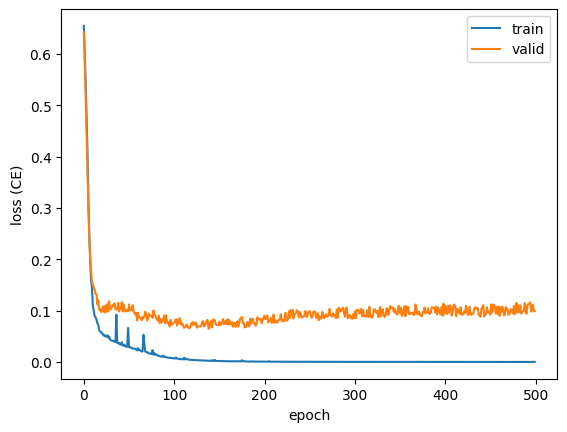

In [10]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss (CE)')
plt.legend()
plt.show()

#### Training with patience and early stopping

In [11]:
# Instantiate a fresh model
net = Net(X_train.shape[1])
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [13]:
train_losses, val_losses, train_accuracy, val_accuracy = train_model(
    net, train_dataloader, val_dataloader, criterion, optimizer, patience=30, epochs=500
)

[epoch 1] Training: loss=0.665 accuracy=0.536 |	 Valid: loss=0.631 accuracy=0.789
[epoch 2] Training: loss=0.599 accuracy=0.910 |	 Valid: loss=0.570 accuracy=0.921
[epoch 3] Training: loss=0.538 accuracy=0.954 |	 Valid: loss=0.502 accuracy=0.921
[epoch 4] Training: loss=0.471 accuracy=0.954 |	 Valid: loss=0.429 accuracy=0.912
[epoch 5] Training: loss=0.375 accuracy=0.949 |	 Valid: loss=0.350 accuracy=0.912
[epoch 6] Training: loss=0.311 accuracy=0.954 |	 Valid: loss=0.286 accuracy=0.904
[epoch 7] Training: loss=0.236 accuracy=0.954 |	 Valid: loss=0.233 accuracy=0.912
[epoch 8] Training: loss=0.186 accuracy=0.958 |	 Valid: loss=0.204 accuracy=0.912
[epoch 9] Training: loss=0.149 accuracy=0.960 |	 Valid: loss=0.189 accuracy=0.912
[epoch 10] Training: loss=0.133 accuracy=0.967 |	 Valid: loss=0.174 accuracy=0.921
[epoch 11] Training: loss=0.108 accuracy=0.969 |	 Valid: loss=0.159 accuracy=0.939
[epoch 12] Training: loss=0.098 accuracy=0.969 |	 Valid: loss=0.143 accuracy=0.939
[epoch 13] Tr

[epoch 105] Training: loss=0.009 accuracy=0.996 |	 Valid: loss=0.098 accuracy=0.982
[epoch 106] Training: loss=0.009 accuracy=0.996 |	 Valid: loss=0.101 accuracy=0.982
[epoch 107] Training: loss=0.009 accuracy=0.996 |	 Valid: loss=0.102 accuracy=0.974
[epoch 108] Training: loss=0.011 accuracy=0.996 |	 Valid: loss=0.116 accuracy=0.982
[epoch 109] Training: loss=0.008 accuracy=0.998 |	 Valid: loss=0.112 accuracy=0.982
[epoch 110] Training: loss=0.010 accuracy=0.998 |	 Valid: loss=0.098 accuracy=0.982
[epoch 111] Training: loss=0.008 accuracy=0.996 |	 Valid: loss=0.099 accuracy=0.982
[epoch 112] Training: loss=0.007 accuracy=0.998 |	 Valid: loss=0.097 accuracy=0.982
[epoch 113] Training: loss=0.008 accuracy=0.998 |	 Valid: loss=0.117 accuracy=0.982
[epoch 114] Training: loss=0.009 accuracy=0.998 |	 Valid: loss=0.103 accuracy=0.982
[epoch 115] Training: loss=0.007 accuracy=0.998 |	 Valid: loss=0.097 accuracy=0.982
[epoch 116] Training: loss=0.007 accuracy=0.998 |	 Valid: loss=0.100 accurac

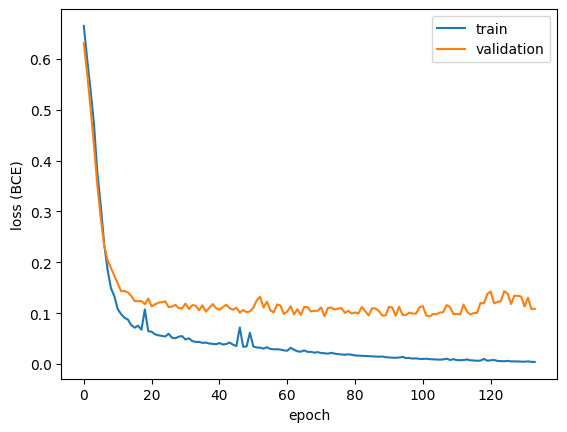

In [15]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss (BCE)')
plt.legend()
plt.show()

## Regularization with network architecture

#### Training a large model

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
X, y = fetch_california_housing(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float32), y.astype(np.float32), test_size=0.2, random_state=0)

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
class CaliforniaDataset(Dataset):
    def __init__(self, X: np.array, y: np.array):         
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor]:
        return self.X[idx], self.y[idx]

In [6]:
# Instantiate datasets
training_data = CaliforniaDataset(X_train, y_train)
test_data = CaliforniaDataset(X_test, y_test)
# Instantiate data loaders
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int = 128):
        super(Net, self).__init__()
        self.hidden_units = hidden_units
        self.fc1 = nn.Linear(input_shape, self.hidden_units)
        self.fc2 = nn.Linear(self.hidden_units, self.hidden_units)
        self.fc3 = nn.Linear(self.hidden_units, self.hidden_units)
        self.fc4 = nn.Linear(self.hidden_units, self.hidden_units)
        self.fc5 = nn.Linear(self.hidden_units, self.hidden_units)
        self.output = nn.Linear(self.hidden_units, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        output = self.output(x)
        return output

In [8]:
# Instantiate the network
net = Net(X_train.shape[1])
# Generate one random sample of 8 features
random_data = torch.rand((1, X_train.shape[1]))
# Compute the forward propagation
print(net(random_data))

tensor([[0.0041]], grad_fn=<AddmmBackward0>)


In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [10]:
def epoch_step(net, dataloader, training_set: bool):
    running_loss = 0.
    correct = 0.
    for i, data in enumerate(dataloader, 0):
        # Get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.unsqueeze(1)
        if training_set:
            # Zero the parameter gradients
            optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        if training_set:
            loss.backward()
            optimizer.step()
        # Compute loss for this batch
        running_loss += loss.item()

    return running_loss

In [11]:
def train_model(net, train_dataloader, test_dataloader, criterion, optimizer, epochs):
    train_losses = []
    test_losses = []
    # Loop over the dataset one time per epoch
    for epoch in range(epochs):  
        # Reset the loss for this epoch
        net.train()
        running_train_loss = epoch_step(net, dataloader=train_dataloader, training_set=True)

        # Compute the loss for this epoch and add it to the list
        train_epoch_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_epoch_loss)

        ## Evaluate the model on the test set
        net.eval()
        with torch.no_grad():
            running_test_loss = epoch_step(net, dataloader=test_dataloader, training_set=False)

            test_epoch_loss = running_test_loss / len(test_dataloader)
            test_losses.append(test_epoch_loss)

        # Print stats
        print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} | Test: loss={test_epoch_loss:.3f} ')

    print('Finished Training')
    
    return train_losses, test_losses

In [11]:
train_losses, test_losses = train_model(net, train_dataloader, test_dataloader, criterion, optimizer, 500)

[epoch 1] Training: loss=0.936 | Test: loss=0.400 
[epoch 2] Training: loss=0.379 | Test: loss=0.367 
[epoch 3] Training: loss=0.357 | Test: loss=0.331 
[epoch 4] Training: loss=0.340 | Test: loss=0.351 
[epoch 5] Training: loss=0.330 | Test: loss=0.322 
[epoch 6] Training: loss=0.318 | Test: loss=0.442 
[epoch 7] Training: loss=0.317 | Test: loss=0.304 
[epoch 8] Training: loss=0.305 | Test: loss=0.309 
[epoch 9] Training: loss=0.296 | Test: loss=0.302 
[epoch 10] Training: loss=0.289 | Test: loss=0.289 
[epoch 11] Training: loss=0.282 | Test: loss=0.300 
[epoch 12] Training: loss=0.282 | Test: loss=0.282 
[epoch 13] Training: loss=0.281 | Test: loss=0.288 
[epoch 14] Training: loss=0.298 | Test: loss=0.295 
[epoch 15] Training: loss=0.277 | Test: loss=0.277 
[epoch 16] Training: loss=0.279 | Test: loss=0.282 
[epoch 17] Training: loss=0.271 | Test: loss=0.279 
[epoch 18] Training: loss=0.270 | Test: loss=0.276 
[epoch 19] Training: loss=0.263 | Test: loss=0.273 
[epoch 20] Training: 

[epoch 158] Training: loss=0.062 | Test: loss=0.302 
[epoch 159] Training: loss=0.061 | Test: loss=0.311 
[epoch 160] Training: loss=0.064 | Test: loss=0.300 
[epoch 161] Training: loss=0.065 | Test: loss=0.307 
[epoch 162] Training: loss=0.068 | Test: loss=0.311 
[epoch 163] Training: loss=0.066 | Test: loss=0.304 
[epoch 164] Training: loss=0.073 | Test: loss=0.304 
[epoch 165] Training: loss=0.065 | Test: loss=0.307 
[epoch 166] Training: loss=0.059 | Test: loss=0.296 
[epoch 167] Training: loss=0.056 | Test: loss=0.301 
[epoch 168] Training: loss=0.055 | Test: loss=0.293 
[epoch 169] Training: loss=0.055 | Test: loss=0.306 
[epoch 170] Training: loss=0.058 | Test: loss=0.303 
[epoch 171] Training: loss=0.060 | Test: loss=0.302 
[epoch 172] Training: loss=0.064 | Test: loss=0.313 
[epoch 173] Training: loss=0.059 | Test: loss=0.306 
[epoch 174] Training: loss=0.055 | Test: loss=0.309 
[epoch 175] Training: loss=0.056 | Test: loss=0.307 
[epoch 176] Training: loss=0.054 | Test: loss=

[epoch 313] Training: loss=0.026 | Test: loss=0.324 
[epoch 314] Training: loss=0.033 | Test: loss=0.310 
[epoch 315] Training: loss=0.032 | Test: loss=0.317 
[epoch 316] Training: loss=0.036 | Test: loss=0.310 
[epoch 317] Training: loss=0.030 | Test: loss=0.328 
[epoch 318] Training: loss=0.027 | Test: loss=0.311 
[epoch 319] Training: loss=0.023 | Test: loss=0.312 
[epoch 320] Training: loss=0.025 | Test: loss=0.314 
[epoch 321] Training: loss=0.029 | Test: loss=0.323 
[epoch 322] Training: loss=0.031 | Test: loss=0.319 
[epoch 323] Training: loss=0.032 | Test: loss=0.336 
[epoch 324] Training: loss=0.026 | Test: loss=0.340 
[epoch 325] Training: loss=0.032 | Test: loss=0.307 
[epoch 326] Training: loss=0.023 | Test: loss=0.302 
[epoch 327] Training: loss=0.020 | Test: loss=0.312 
[epoch 328] Training: loss=0.020 | Test: loss=0.301 
[epoch 329] Training: loss=0.022 | Test: loss=0.315 
[epoch 330] Training: loss=0.025 | Test: loss=0.319 
[epoch 331] Training: loss=0.028 | Test: loss=

[epoch 468] Training: loss=0.017 | Test: loss=0.311 
[epoch 469] Training: loss=0.016 | Test: loss=0.311 
[epoch 470] Training: loss=0.020 | Test: loss=0.313 
[epoch 471] Training: loss=0.015 | Test: loss=0.313 
[epoch 472] Training: loss=0.014 | Test: loss=0.309 
[epoch 473] Training: loss=0.015 | Test: loss=0.310 
[epoch 474] Training: loss=0.013 | Test: loss=0.312 
[epoch 475] Training: loss=0.014 | Test: loss=0.312 
[epoch 476] Training: loss=0.019 | Test: loss=0.306 
[epoch 477] Training: loss=0.020 | Test: loss=0.313 
[epoch 478] Training: loss=0.018 | Test: loss=0.305 
[epoch 479] Training: loss=0.022 | Test: loss=0.312 
[epoch 480] Training: loss=0.025 | Test: loss=0.327 
[epoch 481] Training: loss=0.024 | Test: loss=0.321 
[epoch 482] Training: loss=0.016 | Test: loss=0.316 
[epoch 483] Training: loss=0.026 | Test: loss=0.304 
[epoch 484] Training: loss=0.016 | Test: loss=0.310 
[epoch 485] Training: loss=0.015 | Test: loss=0.303 
[epoch 486] Training: loss=0.013 | Test: loss=

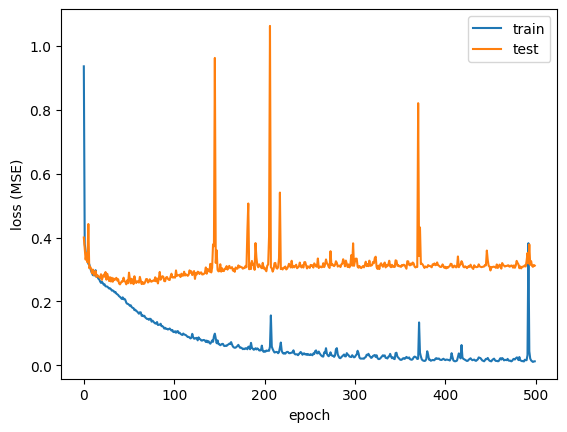

In [12]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (MSE)')
plt.legend()
plt.show()

In [13]:
# Compute the predictions with the trained neural network
y_train_pred = net(torch.tensor((X_train))).detach().numpy()
y_test_pred = net(torch.tensor((X_test))).detach().numpy()
# Compute the R2-score
print('R2-score on training set:', r2_score(y_train, y_train_pred))
print('R2-score on test set:', r2_score(y_test, y_test_pred))

R2-score on training set: 0.9922777453770203
R2-score on test set: 0.7610035849523354


#### Regularizing with a smaller network

In [13]:
class Net(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int = 16):
        super(Net, self).__init__()
        self.hidden_units = hidden_units
        self.fc1 = nn.Linear(input_shape, self.hidden_units)
        self.fc2 = nn.Linear(self.hidden_units, self.hidden_units)
        self.output = nn.Linear(self.hidden_units, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = self.output(x)
        return output

In [14]:
# Instantiate the network
net = Net(X_train.shape[1])
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [16]:
train_losses, test_losses = train_model(net, train_dataloader, test_dataloader, criterion, optimizer, 500)

[epoch 1] Training: loss=2.222 | Test: loss=1.843 
[epoch 2] Training: loss=0.651 | Test: loss=0.645 
[epoch 3] Training: loss=0.482 | Test: loss=0.455 
[epoch 4] Training: loss=0.432 | Test: loss=0.426 
[epoch 5] Training: loss=0.412 | Test: loss=0.402 
[epoch 6] Training: loss=0.400 | Test: loss=0.399 
[epoch 7] Training: loss=0.391 | Test: loss=0.393 
[epoch 8] Training: loss=0.382 | Test: loss=0.387 
[epoch 9] Training: loss=0.377 | Test: loss=0.375 
[epoch 10] Training: loss=0.372 | Test: loss=0.367 
[epoch 11] Training: loss=0.366 | Test: loss=0.370 
[epoch 12] Training: loss=0.361 | Test: loss=0.371 
[epoch 13] Training: loss=0.356 | Test: loss=0.361 
[epoch 14] Training: loss=0.351 | Test: loss=0.346 
[epoch 15] Training: loss=0.349 | Test: loss=0.345 
[epoch 16] Training: loss=0.344 | Test: loss=0.339 
[epoch 17] Training: loss=0.340 | Test: loss=0.338 
[epoch 18] Training: loss=0.337 | Test: loss=0.337 
[epoch 19] Training: loss=0.332 | Test: loss=0.329 
[epoch 20] Training: 

[epoch 158] Training: loss=0.265 | Test: loss=0.280 
[epoch 159] Training: loss=0.265 | Test: loss=0.275 
[epoch 160] Training: loss=0.265 | Test: loss=0.589 
[epoch 161] Training: loss=0.277 | Test: loss=0.287 
[epoch 162] Training: loss=0.265 | Test: loss=0.276 
[epoch 163] Training: loss=0.264 | Test: loss=0.278 
[epoch 164] Training: loss=0.264 | Test: loss=0.277 
[epoch 165] Training: loss=0.263 | Test: loss=0.279 
[epoch 166] Training: loss=0.264 | Test: loss=0.284 
[epoch 167] Training: loss=0.264 | Test: loss=0.273 
[epoch 168] Training: loss=0.265 | Test: loss=0.277 
[epoch 169] Training: loss=0.264 | Test: loss=0.275 
[epoch 170] Training: loss=0.265 | Test: loss=0.273 
[epoch 171] Training: loss=0.263 | Test: loss=0.275 
[epoch 172] Training: loss=0.264 | Test: loss=0.274 
[epoch 173] Training: loss=0.263 | Test: loss=0.280 
[epoch 174] Training: loss=0.264 | Test: loss=0.272 
[epoch 175] Training: loss=0.263 | Test: loss=0.271 
[epoch 176] Training: loss=0.263 | Test: loss=

[epoch 313] Training: loss=0.256 | Test: loss=0.282 
[epoch 314] Training: loss=0.256 | Test: loss=0.267 
[epoch 315] Training: loss=0.254 | Test: loss=0.270 
[epoch 316] Training: loss=0.255 | Test: loss=0.268 
[epoch 317] Training: loss=0.255 | Test: loss=0.271 
[epoch 318] Training: loss=0.254 | Test: loss=0.574 
[epoch 319] Training: loss=0.268 | Test: loss=0.275 
[epoch 320] Training: loss=0.255 | Test: loss=0.270 
[epoch 321] Training: loss=0.254 | Test: loss=0.273 
[epoch 322] Training: loss=0.255 | Test: loss=0.272 
[epoch 323] Training: loss=0.254 | Test: loss=0.279 
[epoch 324] Training: loss=0.254 | Test: loss=0.271 
[epoch 325] Training: loss=0.254 | Test: loss=0.272 
[epoch 326] Training: loss=0.254 | Test: loss=0.278 
[epoch 327] Training: loss=0.253 | Test: loss=0.274 
[epoch 328] Training: loss=0.254 | Test: loss=0.271 
[epoch 329] Training: loss=0.254 | Test: loss=0.279 
[epoch 330] Training: loss=0.254 | Test: loss=0.269 
[epoch 331] Training: loss=0.254 | Test: loss=

[epoch 468] Training: loss=0.249 | Test: loss=0.276 
[epoch 469] Training: loss=0.249 | Test: loss=0.274 
[epoch 470] Training: loss=0.250 | Test: loss=0.274 
[epoch 471] Training: loss=0.250 | Test: loss=0.272 
[epoch 472] Training: loss=0.249 | Test: loss=0.269 
[epoch 473] Training: loss=0.250 | Test: loss=0.270 
[epoch 474] Training: loss=0.249 | Test: loss=0.278 
[epoch 475] Training: loss=0.250 | Test: loss=0.283 
[epoch 476] Training: loss=0.250 | Test: loss=0.273 
[epoch 477] Training: loss=0.249 | Test: loss=0.271 
[epoch 478] Training: loss=0.249 | Test: loss=0.276 
[epoch 479] Training: loss=0.248 | Test: loss=0.288 
[epoch 480] Training: loss=0.249 | Test: loss=0.270 
[epoch 481] Training: loss=0.248 | Test: loss=0.270 
[epoch 482] Training: loss=0.249 | Test: loss=0.303 
[epoch 483] Training: loss=0.274 | Test: loss=0.276 
[epoch 484] Training: loss=0.253 | Test: loss=0.283 
[epoch 485] Training: loss=0.248 | Test: loss=0.269 
[epoch 486] Training: loss=0.248 | Test: loss=

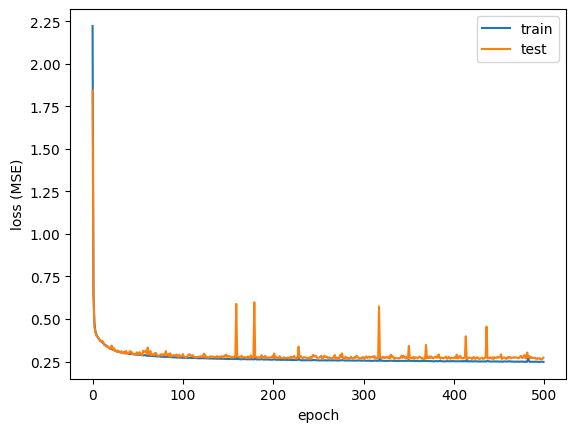

In [17]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (MSE)')
plt.legend()
plt.show()

In [18]:
# Compute the predictions with the trained neural network
y_train_pred = net(torch.tensor((X_train))).detach().numpy()
y_test_pred = net(torch.tensor((X_test))).detach().numpy()
# Compute the R2-score
print('R2-score on training set:', r2_score(y_train, y_train_pred))
print('R2-score on test set:', r2_score(y_test, y_test_pred))

R2-score on training set: 0.8161885562733123
R2-score on test set: 0.7906037325658601


## Regularizing with dropout

#### Without dropout

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
X, y = load_digits(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float32), y.astype(np.int64), test_size=0.2, random_state=0)

In [4]:
class DigitsDataset(Dataset):
    def __init__(self, X: np.array, y: np.array):      
        self.X = torch.from_numpy(X/255)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor]:
        return self.X[idx], self.y[idx]

In [5]:
# Instantiate datasets
training_data = DigitsDataset(X_train, y_train)
test_data = DigitsDataset(X_test, y_test)
# Instantiate data loaders
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int = 128, dropout: float = 0.25):
        super(Net, self).__init__()
        self.hidden_units = hidden_units
        self.fc1 = nn.Linear(input_shape, self.hidden_units)
        self.fc2 = nn.Linear(self.hidden_units, self.hidden_units)
        self.fc3 = nn.Linear(self.hidden_units, self.hidden_units)
        self.dropout = nn.Dropout(p=dropout)
        self.output = nn.Linear(self.hidden_units, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        output = torch.softmax(self.output(x), dim=1)
        return output

In [7]:
# Instantiate the model
net = Net(X_train.shape[1], dropout=0)
# Generate randomly one random 28x28 image as a 784 values tensor
random_data = torch.rand((1, 64))
result = net(random_data)
print('Resulting output tensor:', result)
print('Sum of the output tensor:', result.sum())

Resulting output tensor: tensor([[0.1057, 0.1001, 0.1062, 0.1010, 0.0981, 0.0909, 0.0988, 0.0909, 0.1115,
         0.0969]], grad_fn=<SoftmaxBackward0>)
Sum of the output tensor: tensor(1.0000, grad_fn=<SumBackward0>)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [9]:
def epoch_step(net, dataloader, training_set: bool):
    running_loss = 0.
    correct = 0.
    for i, data in enumerate(dataloader, 0):
        # Get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        if training_set:
            # Zero the parameter gradients
            optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        if training_set:
            loss.backward()
            optimizer.step()
        # Add correct predictions for this batch
        correct += (outputs.argmax(dim=1) == labels).float().sum()
        # Compute loss for this batch
        running_loss += loss.item()

    return running_loss, correct

In [10]:
def train_model(net, train_dataloader, test_dataloader, criterion, optimizer, epochs):
    # Create empty lists to store the losses and accuracies
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []

    # Loop over the dataset
    for epoch in range(epochs):  
        ## Train the model on the training set
        net.train()
        running_train_loss, correct = epoch_step(net, dataloader=train_dataloader, training_set=True)
        # Compute and store loss and accuracy for this epoch
        train_epoch_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_epoch_loss)
        train_epoch_accuracy = correct / len(training_data)
        train_accuracy.append(train_epoch_accuracy)

        ## Evaluate the model on the test set
        net.eval()
        with torch.no_grad():
            running_test_loss, correct = epoch_step(net, dataloader=test_dataloader, training_set=False)

            test_epoch_loss = running_test_loss / len(test_dataloader)
            test_losses.append(test_epoch_loss)
            test_epoch_accuracy = correct / len(test_data)
            test_accuracy.append(test_epoch_accuracy)

        # Print stats
        print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
    \t Test: loss={test_epoch_loss:.3f} accuracy={test_epoch_accuracy:.3f}')

    print('Finished Training')

    return train_losses, test_losses, train_accuracy, test_accuracy

In [11]:
train_losses, test_losses, train_accuracy, test_accuracy = train_model(
    net, train_dataloader, test_dataloader, criterion, optimizer, epochs=500
)

[epoch 1] Training: loss=2.303 accuracy=0.097 |    	 Test: loss=2.303 accuracy=0.081
[epoch 2] Training: loss=2.302 accuracy=0.112 |    	 Test: loss=2.301 accuracy=0.147
[epoch 3] Training: loss=2.296 accuracy=0.206 |    	 Test: loss=2.288 accuracy=0.144
[epoch 4] Training: loss=2.245 accuracy=0.218 |    	 Test: loss=2.230 accuracy=0.219
[epoch 5] Training: loss=2.180 accuracy=0.289 |    	 Test: loss=2.185 accuracy=0.339
[epoch 6] Training: loss=2.109 accuracy=0.399 |    	 Test: loss=2.091 accuracy=0.447
[epoch 7] Training: loss=2.013 accuracy=0.517 |    	 Test: loss=2.020 accuracy=0.456
[epoch 8] Training: loss=1.943 accuracy=0.557 |    	 Test: loss=1.953 accuracy=0.561
[epoch 9] Training: loss=1.896 accuracy=0.609 |    	 Test: loss=1.900 accuracy=0.603
[epoch 10] Training: loss=1.853 accuracy=0.636 |    	 Test: loss=1.882 accuracy=0.619
[epoch 11] Training: loss=1.817 accuracy=0.683 |    	 Test: loss=1.851 accuracy=0.642
[epoch 12] Training: loss=1.798 accuracy=0.706 |    	 Test: los

[epoch 98] Training: loss=1.522 accuracy=0.943 |    	 Test: loss=1.549 accuracy=0.922
[epoch 99] Training: loss=1.519 accuracy=0.947 |    	 Test: loss=1.555 accuracy=0.914
[epoch 100] Training: loss=1.523 accuracy=0.944 |    	 Test: loss=1.551 accuracy=0.925
[epoch 101] Training: loss=1.524 accuracy=0.946 |    	 Test: loss=1.552 accuracy=0.919
[epoch 102] Training: loss=1.522 accuracy=0.948 |    	 Test: loss=1.551 accuracy=0.914
[epoch 103] Training: loss=1.519 accuracy=0.951 |    	 Test: loss=1.559 accuracy=0.911
[epoch 104] Training: loss=1.518 accuracy=0.949 |    	 Test: loss=1.554 accuracy=0.925
[epoch 105] Training: loss=1.516 accuracy=0.951 |    	 Test: loss=1.549 accuracy=0.917
[epoch 106] Training: loss=1.516 accuracy=0.953 |    	 Test: loss=1.546 accuracy=0.917
[epoch 107] Training: loss=1.516 accuracy=0.950 |    	 Test: loss=1.549 accuracy=0.914
[epoch 108] Training: loss=1.515 accuracy=0.952 |    	 Test: loss=1.545 accuracy=0.914
[epoch 109] Training: loss=1.517 accuracy=0.9

[epoch 194] Training: loss=1.491 accuracy=0.971 |    	 Test: loss=1.533 accuracy=0.928
[epoch 195] Training: loss=1.494 accuracy=0.971 |    	 Test: loss=1.533 accuracy=0.936
[epoch 196] Training: loss=1.492 accuracy=0.971 |    	 Test: loss=1.536 accuracy=0.928
[epoch 197] Training: loss=1.491 accuracy=0.971 |    	 Test: loss=1.536 accuracy=0.925
[epoch 198] Training: loss=1.492 accuracy=0.971 |    	 Test: loss=1.530 accuracy=0.931
[epoch 199] Training: loss=1.493 accuracy=0.971 |    	 Test: loss=1.540 accuracy=0.928
[epoch 200] Training: loss=1.491 accuracy=0.971 |    	 Test: loss=1.536 accuracy=0.919
[epoch 201] Training: loss=1.493 accuracy=0.971 |    	 Test: loss=1.534 accuracy=0.925
[epoch 202] Training: loss=1.491 accuracy=0.971 |    	 Test: loss=1.536 accuracy=0.936
[epoch 203] Training: loss=1.491 accuracy=0.971 |    	 Test: loss=1.529 accuracy=0.933
[epoch 204] Training: loss=1.493 accuracy=0.971 |    	 Test: loss=1.537 accuracy=0.925
[epoch 205] Training: loss=1.493 accuracy=0

[epoch 289] Training: loss=1.490 accuracy=0.971 |    	 Test: loss=1.530 accuracy=0.939
[epoch 290] Training: loss=1.489 accuracy=0.972 |    	 Test: loss=1.526 accuracy=0.931
[epoch 291] Training: loss=1.489 accuracy=0.973 |    	 Test: loss=1.521 accuracy=0.942
[epoch 292] Training: loss=1.489 accuracy=0.973 |    	 Test: loss=1.527 accuracy=0.931
[epoch 293] Training: loss=1.488 accuracy=0.974 |    	 Test: loss=1.518 accuracy=0.944
[epoch 294] Training: loss=1.489 accuracy=0.972 |    	 Test: loss=1.525 accuracy=0.933
[epoch 295] Training: loss=1.489 accuracy=0.972 |    	 Test: loss=1.530 accuracy=0.931
[epoch 296] Training: loss=1.487 accuracy=0.975 |    	 Test: loss=1.530 accuracy=0.933
[epoch 297] Training: loss=1.486 accuracy=0.975 |    	 Test: loss=1.526 accuracy=0.936
[epoch 298] Training: loss=1.486 accuracy=0.975 |    	 Test: loss=1.531 accuracy=0.939
[epoch 299] Training: loss=1.487 accuracy=0.975 |    	 Test: loss=1.530 accuracy=0.933
[epoch 300] Training: loss=1.487 accuracy=0

[epoch 384] Training: loss=1.478 accuracy=0.985 |    	 Test: loss=1.523 accuracy=0.942
[epoch 385] Training: loss=1.477 accuracy=0.985 |    	 Test: loss=1.515 accuracy=0.939
[epoch 386] Training: loss=1.477 accuracy=0.985 |    	 Test: loss=1.519 accuracy=0.939
[epoch 387] Training: loss=1.476 accuracy=0.985 |    	 Test: loss=1.515 accuracy=0.942
[epoch 388] Training: loss=1.476 accuracy=0.985 |    	 Test: loss=1.519 accuracy=0.939
[epoch 389] Training: loss=1.476 accuracy=0.985 |    	 Test: loss=1.517 accuracy=0.942
[epoch 390] Training: loss=1.476 accuracy=0.985 |    	 Test: loss=1.516 accuracy=0.944
[epoch 391] Training: loss=1.476 accuracy=0.985 |    	 Test: loss=1.520 accuracy=0.944
[epoch 392] Training: loss=1.476 accuracy=0.985 |    	 Test: loss=1.517 accuracy=0.939
[epoch 393] Training: loss=1.477 accuracy=0.985 |    	 Test: loss=1.517 accuracy=0.942
[epoch 394] Training: loss=1.476 accuracy=0.985 |    	 Test: loss=1.518 accuracy=0.939
[epoch 395] Training: loss=1.477 accuracy=0

[epoch 480] Training: loss=1.497 accuracy=0.964 |    	 Test: loss=1.526 accuracy=0.936
[epoch 481] Training: loss=1.484 accuracy=0.978 |    	 Test: loss=1.520 accuracy=0.939
[epoch 482] Training: loss=1.486 accuracy=0.976 |    	 Test: loss=1.510 accuracy=0.947
[epoch 483] Training: loss=1.482 accuracy=0.981 |    	 Test: loss=1.516 accuracy=0.944
[epoch 484] Training: loss=1.481 accuracy=0.980 |    	 Test: loss=1.518 accuracy=0.944
[epoch 485] Training: loss=1.481 accuracy=0.981 |    	 Test: loss=1.513 accuracy=0.950
[epoch 486] Training: loss=1.479 accuracy=0.985 |    	 Test: loss=1.513 accuracy=0.947
[epoch 487] Training: loss=1.478 accuracy=0.985 |    	 Test: loss=1.516 accuracy=0.950
[epoch 488] Training: loss=1.478 accuracy=0.984 |    	 Test: loss=1.512 accuracy=0.944
[epoch 489] Training: loss=1.482 accuracy=0.981 |    	 Test: loss=1.519 accuracy=0.944
[epoch 490] Training: loss=1.478 accuracy=0.984 |    	 Test: loss=1.515 accuracy=0.944
[epoch 491] Training: loss=1.476 accuracy=0

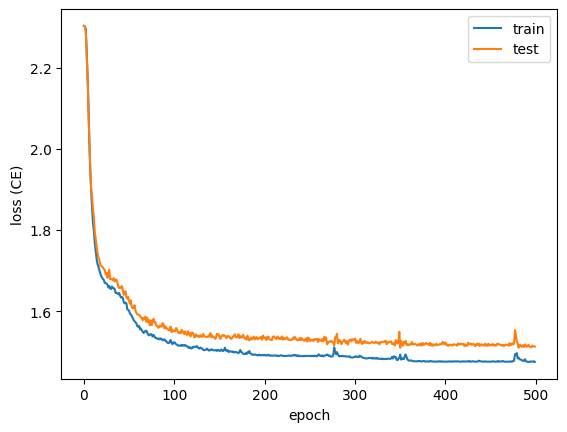

In [12]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (CE)')
plt.legend()
plt.show()

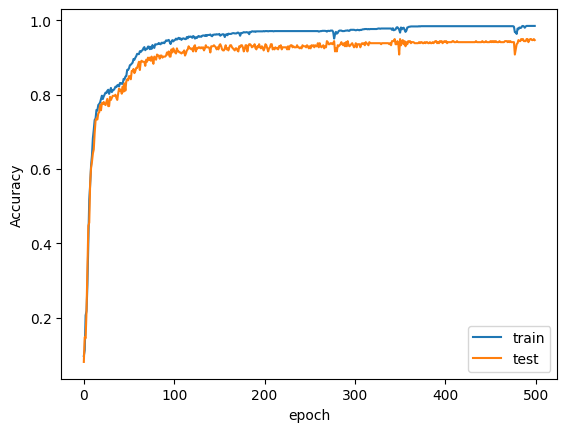

In [13]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### With dropout

In [12]:
# Instantiate the model
net = Net(X_train.shape[1], dropout=0.25)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [15]:
train_losses, test_losses, train_accuracy, test_accuracy = train_model(
    net, train_dataloader, test_dataloader, criterion, optimizer, epochs=500
)

[epoch 1] Training: loss=2.303 accuracy=0.097 |    	 Test: loss=2.303 accuracy=0.111
[epoch 2] Training: loss=2.302 accuracy=0.115 |    	 Test: loss=2.302 accuracy=0.164
[epoch 3] Training: loss=2.300 accuracy=0.185 |    	 Test: loss=2.297 accuracy=0.236
[epoch 4] Training: loss=2.278 accuracy=0.245 |    	 Test: loss=2.255 accuracy=0.164
[epoch 5] Training: loss=2.195 accuracy=0.221 |    	 Test: loss=2.194 accuracy=0.228
[epoch 6] Training: loss=2.125 accuracy=0.339 |    	 Test: loss=2.132 accuracy=0.314
[epoch 7] Training: loss=2.070 accuracy=0.386 |    	 Test: loss=2.081 accuracy=0.322
[epoch 8] Training: loss=2.014 accuracy=0.473 |    	 Test: loss=1.982 accuracy=0.550
[epoch 9] Training: loss=1.966 accuracy=0.534 |    	 Test: loss=1.937 accuracy=0.575
[epoch 10] Training: loss=1.908 accuracy=0.601 |    	 Test: loss=1.868 accuracy=0.647
[epoch 11] Training: loss=1.859 accuracy=0.639 |    	 Test: loss=1.841 accuracy=0.661
[epoch 12] Training: loss=1.827 accuracy=0.655 |    	 Test: los

[epoch 97] Training: loss=1.538 accuracy=0.929 |    	 Test: loss=1.528 accuracy=0.936
[epoch 98] Training: loss=1.536 accuracy=0.930 |    	 Test: loss=1.534 accuracy=0.931
[epoch 99] Training: loss=1.532 accuracy=0.934 |    	 Test: loss=1.523 accuracy=0.942
[epoch 100] Training: loss=1.527 accuracy=0.941 |    	 Test: loss=1.531 accuracy=0.933
[epoch 101] Training: loss=1.526 accuracy=0.939 |    	 Test: loss=1.522 accuracy=0.942
[epoch 102] Training: loss=1.529 accuracy=0.937 |    	 Test: loss=1.528 accuracy=0.936
[epoch 103] Training: loss=1.525 accuracy=0.939 |    	 Test: loss=1.522 accuracy=0.942
[epoch 104] Training: loss=1.523 accuracy=0.945 |    	 Test: loss=1.528 accuracy=0.942
[epoch 105] Training: loss=1.521 accuracy=0.944 |    	 Test: loss=1.527 accuracy=0.936
[epoch 106] Training: loss=1.527 accuracy=0.942 |    	 Test: loss=1.528 accuracy=0.939
[epoch 107] Training: loss=1.531 accuracy=0.934 |    	 Test: loss=1.523 accuracy=0.942
[epoch 108] Training: loss=1.520 accuracy=0.94

[epoch 193] Training: loss=1.484 accuracy=0.981 |    	 Test: loss=1.499 accuracy=0.964
[epoch 194] Training: loss=1.483 accuracy=0.980 |    	 Test: loss=1.499 accuracy=0.958
[epoch 195] Training: loss=1.486 accuracy=0.978 |    	 Test: loss=1.498 accuracy=0.967
[epoch 196] Training: loss=1.488 accuracy=0.976 |    	 Test: loss=1.499 accuracy=0.964
[epoch 197] Training: loss=1.489 accuracy=0.974 |    	 Test: loss=1.495 accuracy=0.967
[epoch 198] Training: loss=1.484 accuracy=0.981 |    	 Test: loss=1.499 accuracy=0.964
[epoch 199] Training: loss=1.487 accuracy=0.976 |    	 Test: loss=1.496 accuracy=0.969
[epoch 200] Training: loss=1.480 accuracy=0.985 |    	 Test: loss=1.500 accuracy=0.967
[epoch 201] Training: loss=1.481 accuracy=0.983 |    	 Test: loss=1.497 accuracy=0.967
[epoch 202] Training: loss=1.484 accuracy=0.979 |    	 Test: loss=1.498 accuracy=0.967
[epoch 203] Training: loss=1.485 accuracy=0.979 |    	 Test: loss=1.499 accuracy=0.964
[epoch 204] Training: loss=1.490 accuracy=0

[epoch 290] Training: loss=1.474 accuracy=0.987 |    	 Test: loss=1.497 accuracy=0.967
[epoch 291] Training: loss=1.477 accuracy=0.985 |    	 Test: loss=1.493 accuracy=0.967
[epoch 292] Training: loss=1.477 accuracy=0.986 |    	 Test: loss=1.496 accuracy=0.967
[epoch 293] Training: loss=1.475 accuracy=0.988 |    	 Test: loss=1.495 accuracy=0.964
[epoch 294] Training: loss=1.478 accuracy=0.984 |    	 Test: loss=1.493 accuracy=0.964
[epoch 295] Training: loss=1.474 accuracy=0.989 |    	 Test: loss=1.495 accuracy=0.964
[epoch 296] Training: loss=1.476 accuracy=0.986 |    	 Test: loss=1.494 accuracy=0.967
[epoch 297] Training: loss=1.476 accuracy=0.985 |    	 Test: loss=1.494 accuracy=0.969
[epoch 298] Training: loss=1.476 accuracy=0.987 |    	 Test: loss=1.492 accuracy=0.969
[epoch 299] Training: loss=1.476 accuracy=0.987 |    	 Test: loss=1.498 accuracy=0.961
[epoch 300] Training: loss=1.476 accuracy=0.986 |    	 Test: loss=1.491 accuracy=0.969
[epoch 301] Training: loss=1.476 accuracy=0

[epoch 386] Training: loss=1.472 accuracy=0.991 |    	 Test: loss=1.486 accuracy=0.978
[epoch 387] Training: loss=1.474 accuracy=0.987 |    	 Test: loss=1.490 accuracy=0.972
[epoch 388] Training: loss=1.474 accuracy=0.987 |    	 Test: loss=1.489 accuracy=0.972
[epoch 389] Training: loss=1.471 accuracy=0.992 |    	 Test: loss=1.486 accuracy=0.972
[epoch 390] Training: loss=1.473 accuracy=0.990 |    	 Test: loss=1.492 accuracy=0.972
[epoch 391] Training: loss=1.472 accuracy=0.989 |    	 Test: loss=1.488 accuracy=0.969
[epoch 392] Training: loss=1.469 accuracy=0.993 |    	 Test: loss=1.491 accuracy=0.972
[epoch 393] Training: loss=1.474 accuracy=0.988 |    	 Test: loss=1.487 accuracy=0.975
[epoch 394] Training: loss=1.474 accuracy=0.987 |    	 Test: loss=1.485 accuracy=0.972
[epoch 395] Training: loss=1.471 accuracy=0.990 |    	 Test: loss=1.487 accuracy=0.975
[epoch 396] Training: loss=1.472 accuracy=0.991 |    	 Test: loss=1.488 accuracy=0.975
[epoch 397] Training: loss=1.471 accuracy=0

[epoch 481] Training: loss=1.471 accuracy=0.990 |    	 Test: loss=1.491 accuracy=0.975
[epoch 482] Training: loss=1.469 accuracy=0.993 |    	 Test: loss=1.487 accuracy=0.975
[epoch 483] Training: loss=1.472 accuracy=0.989 |    	 Test: loss=1.486 accuracy=0.975
[epoch 484] Training: loss=1.472 accuracy=0.990 |    	 Test: loss=1.488 accuracy=0.972
[epoch 485] Training: loss=1.470 accuracy=0.992 |    	 Test: loss=1.487 accuracy=0.975
[epoch 486] Training: loss=1.471 accuracy=0.990 |    	 Test: loss=1.483 accuracy=0.975
[epoch 487] Training: loss=1.469 accuracy=0.992 |    	 Test: loss=1.486 accuracy=0.978
[epoch 488] Training: loss=1.470 accuracy=0.993 |    	 Test: loss=1.488 accuracy=0.972
[epoch 489] Training: loss=1.471 accuracy=0.990 |    	 Test: loss=1.503 accuracy=0.958
[epoch 490] Training: loss=1.475 accuracy=0.988 |    	 Test: loss=1.490 accuracy=0.972
[epoch 491] Training: loss=1.474 accuracy=0.987 |    	 Test: loss=1.491 accuracy=0.972
[epoch 492] Training: loss=1.472 accuracy=0

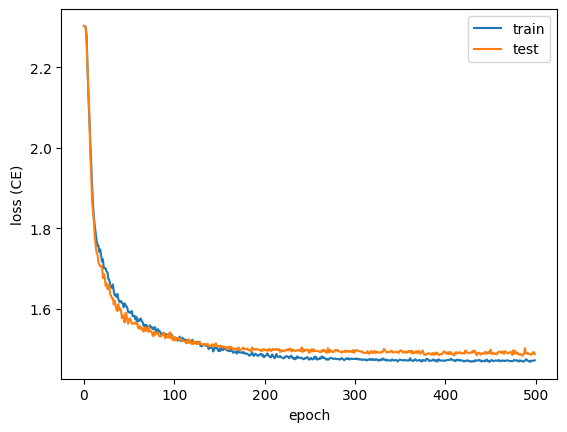

In [16]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (CE)')
plt.legend()
plt.show()

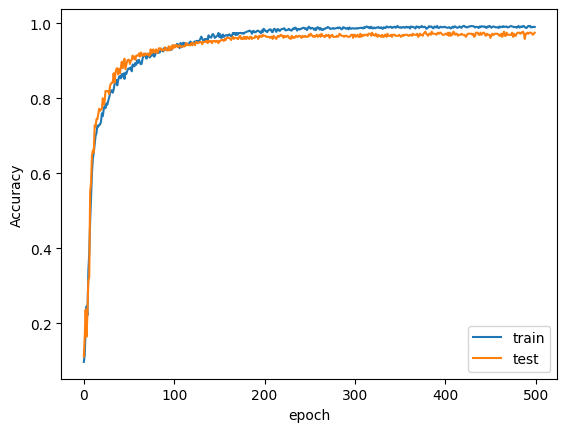

In [17]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()